In [1]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## calin
from cta.nectarcam.feb.I_NmcConfig import NmcConfig

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scsp
from scipy.stats import poisson                                                                                                             

from fit_ses_v6 import *
#import seaborn as sns




/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))


In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
        MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_30pe_newWF.simtel.gz'
        
        inputfile_reader_MC = event_source(
            input_url = MC_file_path,
            max_events=1000)
        all_QMC = []
        all_wfs = []
        for ii, event in enumerate(inputfile_reader_MC):
            all_wfs.append(event.r0.tel[1].waveform[:,:])
            all_QMC.append(event.mc.tel[1].photo_electron_image)
        wfs_MC    = np.array(all_wfs)
        all_QMC   = np.array(all_QMC)

In [4]:
        data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1555.000[0-9].fits.fz"
        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=50000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        all_wfs = []
        pedwfs = []
        for ii, event in enumerate(inputfile_reader):
            Qm = (event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids,:]-250.).sum(axis=1).mean()/58.
            if ii <1000:
                pedwfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
            if Qm >15 and Qm<35:
                all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
                if len(all_wfs)>1000:
                    break
        wfs_data = np.array(all_wfs)
        pedwfs   = np.array(pedwfs).mean(axis=0)

In [5]:
all_wfs=[]

In [6]:
maxs_MC = wfs_MC.argmax(axis=3).flatten()
maxs_data = wfs_data.argmax(axis=3).flatten()

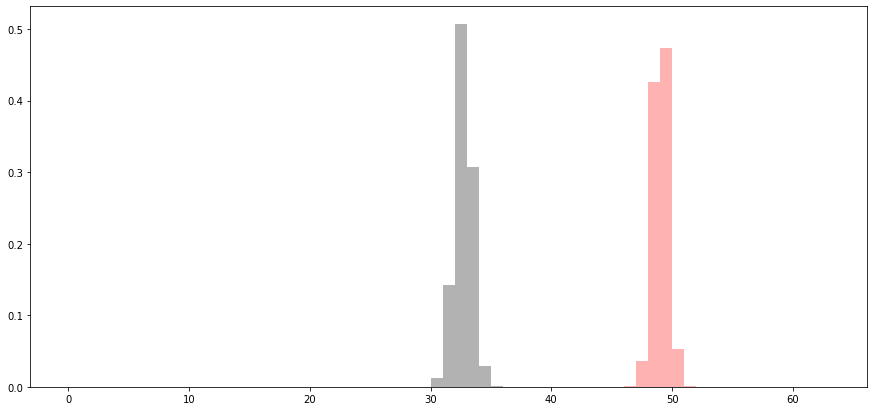

In [7]:
h = plt.hist(maxs_MC,  bins=np.arange(0,64),density=1,alpha=.3,color='red')
h = plt.hist(maxs_data,bins=np.arange(0,64),density=1,alpha=.3,color='black')

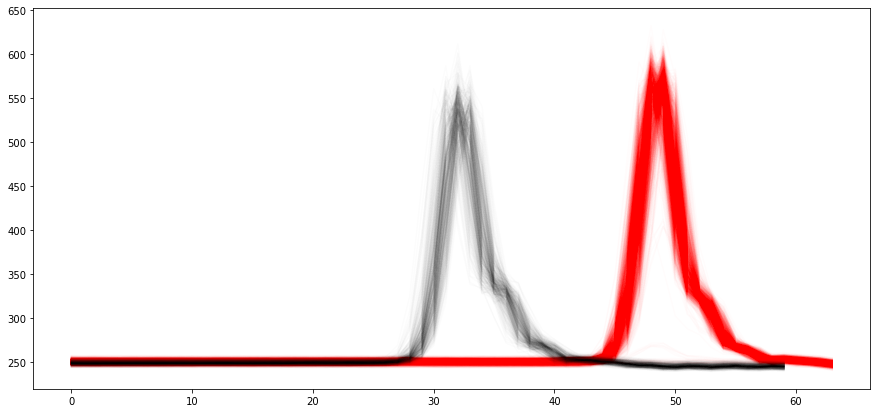

In [8]:
wfs_means_MC = wfs_MC[:,0].mean(axis=0)
wfs_means_data = wfs_data[:,0].mean(axis=0)

p = plt.plot(wfs_means_MC.T,alpha=.01,color='red')
p = plt.plot(wfs_means_data.T,alpha=.01,color='black')

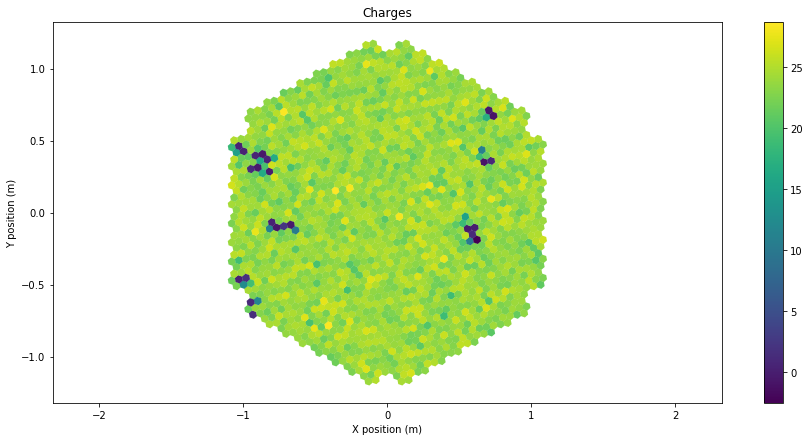

In [30]:

geom = CameraGeometry.from_name("NectarCam-002")

Qs = (wfs_means_MC[:,40:]-250).sum(axis=1)/58.
Qs_data = (wfs_means_data[:,25:45]-250).sum(axis=1)/58.

disp1 = CameraDisplay(geom,title='Charges')
disp1.add_colorbar()
disp1.image = Qs

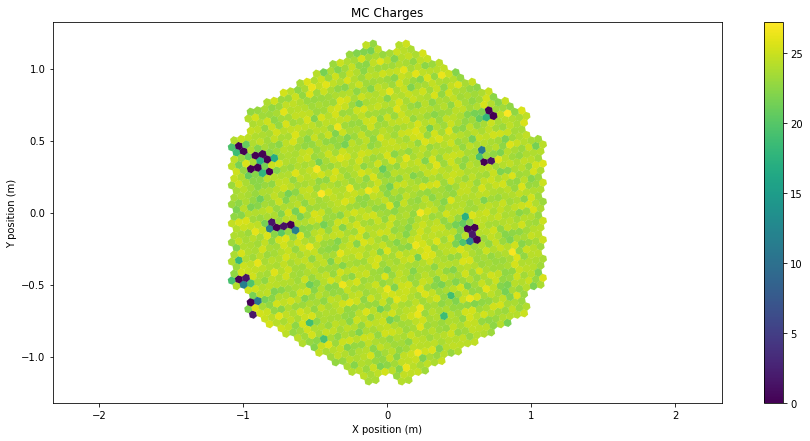

In [10]:
disp1 = CameraDisplay(geom,title='MC Charges')
disp1.add_colorbar()
disp1.image = all_QMC.mean(axis=0)

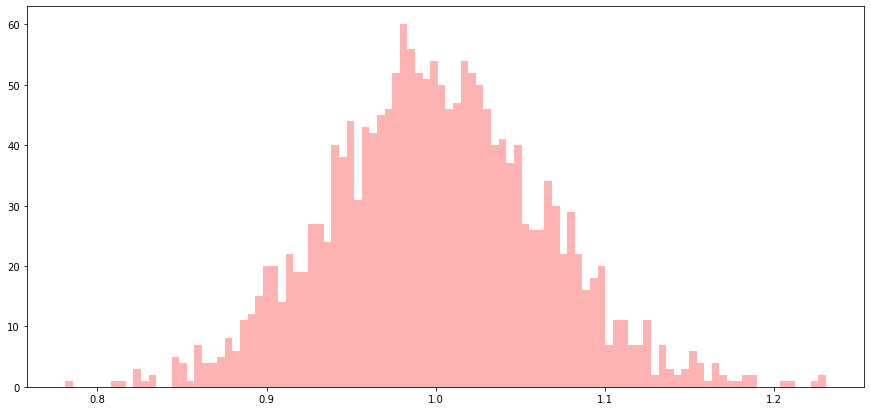

In [31]:
mmask = all_QMC.mean(axis=0)>20
h = plt.hist(Qs[mmask]/all_QMC.mean(axis=0)[mmask],100,color = 'red',alpha=.3)

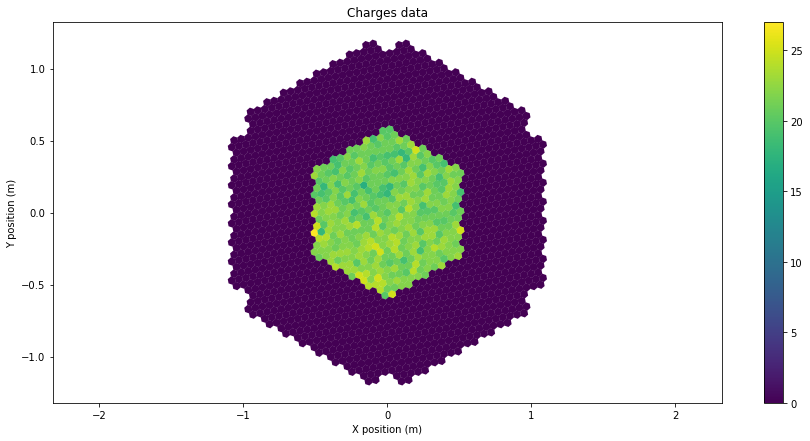

In [12]:
disp1 = CameraDisplay(geom,title='Charges data')
disp1.add_colorbar()
img = np.arange(1855)*0
img[pix_ids] = Qs_data
disp1.image = img

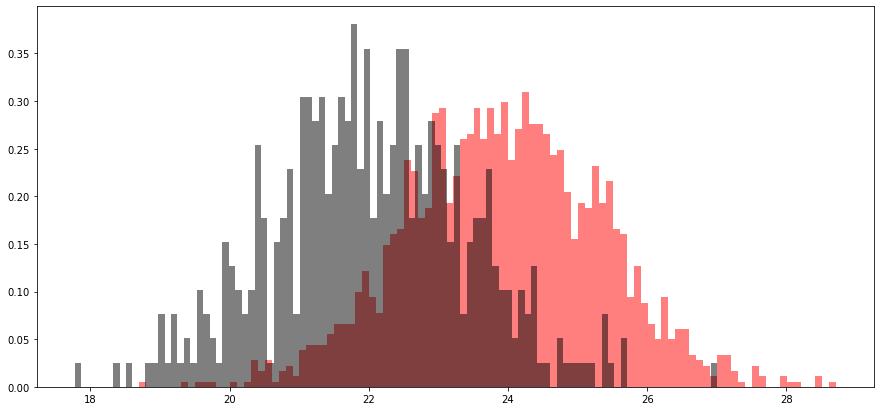

In [32]:
h = plt.hist(Qs[mmask],100,color='red',alpha=.5,density=1)
h = plt.hist(Qs_data,100,color='black',alpha=.5,density=1)

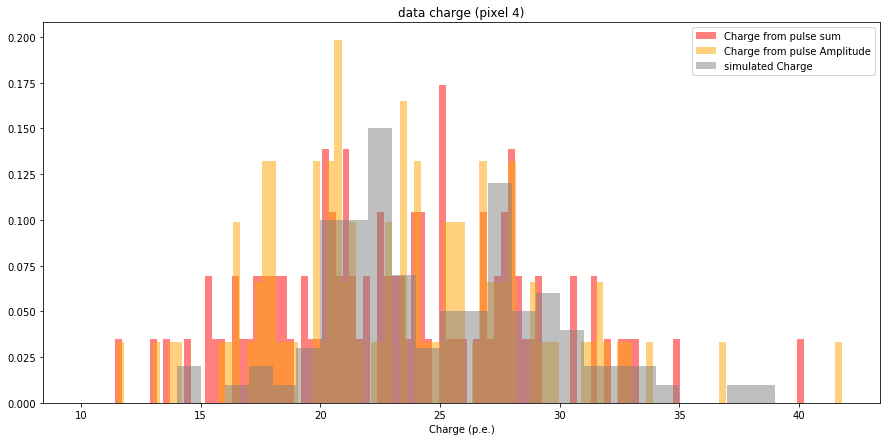

In [34]:
pix = 4
h= plt.hist((wfs_MC[:,0,pix,40:]-250.).sum(axis=1)/58.,100,color='red',alpha=.5,\
           label= "Charge from pulse sum",density=1)
h= plt.hist((wfs_MC[:,0,pix,:]-250.).max(axis=1)/14.,100,color='orange',alpha=.5,\
           label= "Charge from pulse Amplitude",density=1)

h= plt.hist(all_QMC[:,pix],bins=range(10,40),color='grey',alpha=.5,\
           label= "simulated Charge",density=1)

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('Charge (p.e.)')
l = plt.gca().legend()


Text(0, 0.5, 'pulse Amplitude')

/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


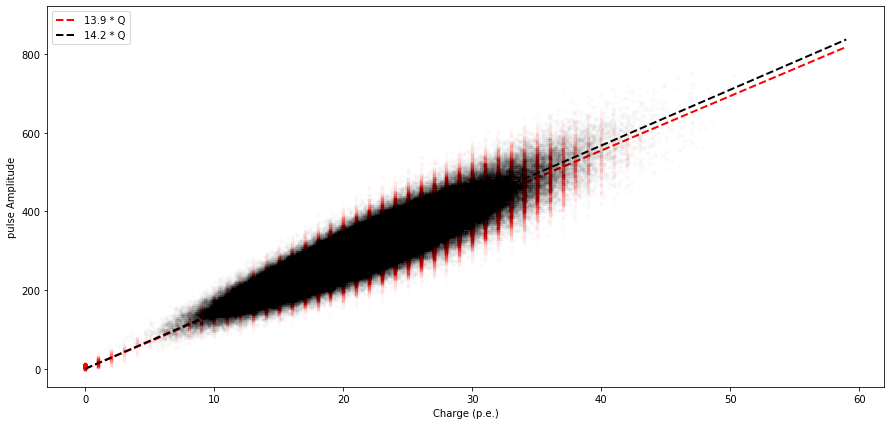

In [15]:
aa = all_QMC.flatten()
bb = (wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()
mm = aa != 0

QA = (bb[mm]/aa[mm]).mean()

pp = plt.plot(all_QMC.flatten(),(wfs_MC[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'red')
pp = plt.plot(np.arange(60),np.arange(60)*QA,'--',color = 'red',\
              lw=2, label="{:.3} * Q".format(QA))

pp = plt.plot(((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten(),(wfs_data[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'black')


QAdat = ((wfs_data[:,0,:,:]-250.).max(axis=2).flatten()/((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten()).mean()

pp = plt.plot(np.arange(60),np.arange(60)*QAdat,'--',color = 'black',\
              lw=2, label="{:.3} * Q".format(QAdat))

plt.gca().legend()
plt.gca().set_xlabel("Charge (p.e.)")
plt.gca().set_ylabel("pulse Amplitude")

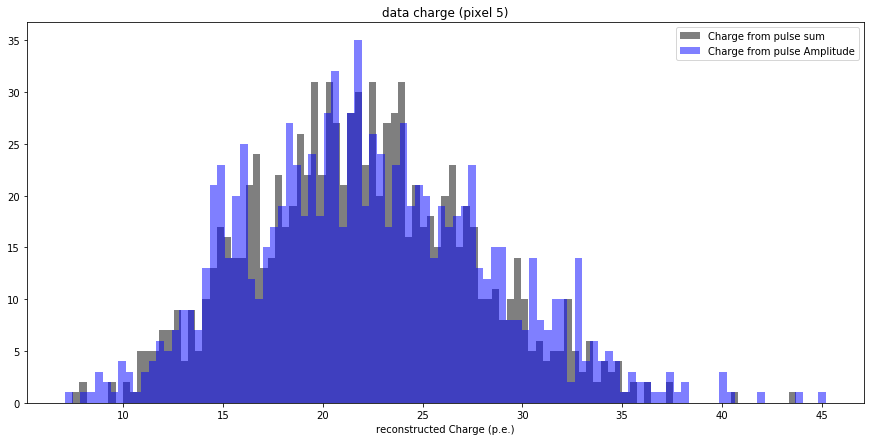

In [16]:
pix = 5
h= plt.hist((wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.,100,color='black',alpha=.5,\
           label= "Charge from pulse sum")
h= plt.hist((wfs_data[:,0,pix,:]-250.).max(axis=1)/14.,100,color='blue',alpha=.5,\
           label= "Charge from pulse Amplitude")

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('reconstructed Charge (p.e.)')
l = plt.gca().legend()


In [17]:
#from cta.MyNectar.scripts.Nectarpipe.MakePTemplate import * 
from MakePTemplate_aftp import GetSyncSpePulseShape_aftp

In [18]:
QAmp = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
pixs=[0,1]
pix=4
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape(wfs_data,500,4,0,pixs,ManualShift = 0,QAmp = 14.)

In [19]:
apt = []
sss = np.arange(0,60,.25)
for pix in range(10):
    pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
    fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)
    apt.append(fct_dat(sss+np.mean(shft_dat))/len(wfs_data))

T_0 : 30.0 ns
shft 1.9638034431605027
Tstd ::  0.430207246261352
T_0 : 30.0 ns
shft 1.931160690720193
Tstd ::  0.41864193469208977
T_0 : 30.0 ns
shft 1.622708994987537
Tstd ::  0.4138451472174006
T_0 : 30.0 ns
shft 1.7148115093939353
Tstd ::  0.4357298829411232
T_0 : 30.0 ns
shft 1.6222271717174037
Tstd ::  0.43418700002338095
T_0 : 30.0 ns
shft 1.7702232381059253
Tstd ::  0.4185795313134291
T_0 : 30.0 ns
shft 2.137394231557137
Tstd ::  0.44880673847228975
T_0 : 30.0 ns
shft 2.6050668842251703
Tstd ::  0.4068477215387372
T_0 : 30.0 ns
shft 2.8622758249076816
Tstd ::  0.4157349641022683
T_0 : 30.0 ns
shft 2.345898972991739
Tstd ::  0.4428162145516029


In [20]:
#pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)

In [21]:
QAmp_MC = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
#fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape(wfs_MC,500,4,0,pixs,ManualShift = 0,QAmp = 14.)
fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape_aftp(wfs_MC[:,0,1,:]-250.,4,ManualShift = 0)

T_0 : 30.0 ns
shft 18.286016392173625
Tstd ::  0.39226525892979003


(20, 50)

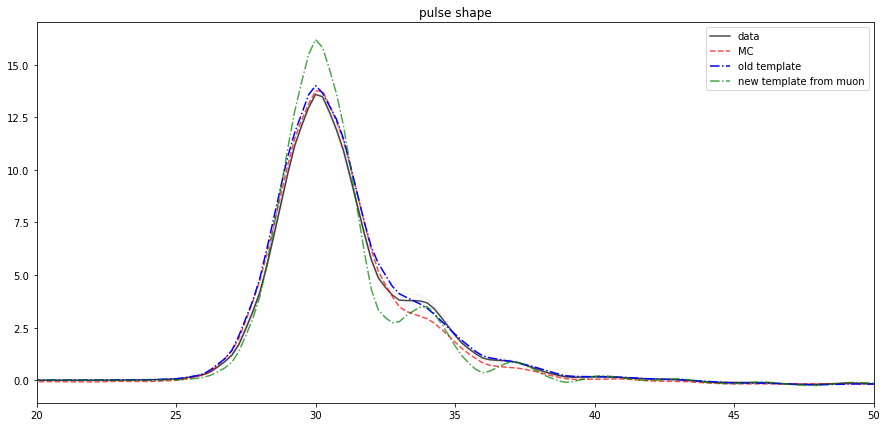

In [35]:
ff2 ="./Pulse_template_nectarCam_22112018.dat"

f= open(ff2,'r')
sss =[]
p_template=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss.append(al[0])
        p_template.append(al[1])

ff2 ="./PT8.dat"

f= open(ff2,'r')
sss2 =[]
p_template2=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss2.append(al[0])
        p_template2.append(al[1])
        
ss = np.arange(60)
apt=np.array(apt)
#plt.plot(sss,fct_dat(sss+np.mean(shft_dat))/len(wfs_data),':',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.mean(axis=0),'-',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.T,'-',color='black',alpha=.02)

plt.plot(sss,fct_mc(sss+np.mean(shft_mc))/len(wfs_MC),'--',color='red',label='MC',alpha=.7)
plt.plot(np.array(sss),p_template,'-.',color='blue',label="old template",alpha=1.)
plt.plot(np.array(sss2),p_template2,'-.',color='green',label="new template from muon",alpha=.7)

l = plt.gca().legend()
plt.gca().set_title('pulse shape')
plt.gca().set_xlim(20,50)

In [23]:
fct_mc(ss+np.mean(shft_mc))[20:40].max()/len(wfs_MC)

13.750289273827274

In [24]:
fct_dat(ss+np.mean(shft_dat))[20:40].max()/len(wfs_data)

13.496788831187931

In [25]:
fct_mc(ss+np.mean(shft_mc))[20:40].sum()/len(wfs_MC)

57.70978622292878

In [26]:
fct_dat(ss+np.mean(shft_dat)).sum()/len(wfs_data)

56.02807308899219

In [27]:
np.array(p_template2)[20*4:40*4:4].sum()

57.986

In [28]:
np.array(p_template)[:].max()

14.002

In [29]:
apt.mean(axis=0).max()

13.589823179396072